In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import inflect

# Regression

In [2]:
df = pd.read_csv('dress_rental_prices.csv',index_col=0)
df.head(10)

,ID,Name,Brand,Colour,Catagories,Price
0,74416,Runway stripe dress,Stella McCartney,beige,dresses,111
1,73815,Reformation Kourtney Dress,Reformation,beige,dresses,50
2,73801,Ivory Viola bridal dress,Ghost,beige,dresses,75
3,73718,Pasu Dress - Rhino Tusk,Coucoo,beige,dresses,37
4,73605,Ellen,RIXO,beige,dresses,47
5,73583,Elena Dress Crystal Garden,Stine Goya,beige,dresses,64
6,73007,OBlanc Dress,New Arrivals,beige,dresses,145
7,73245,Melody Dress,Melissa Odabash,beige,dresses,52
8,73050,Isamaya Dress,Rat & Boa,beige,dresses,38
9,73019,Belted Animal Print Mini Dress,ROTATE BIRGER CHRISTENSEN,beige,dresses,39


In [3]:
df.Colour.unique()

array(['beige', 'black', 'blue', 'brown', 'copper', 'cream', 'gold',
       'green', 'grey', 'multi', 'navy', 'orange', 'phantom', 'pink',
       'purple', 'red', 'silver', 'tan', 'white', 'yellow'], dtype=object)

In [4]:
df.shape

(29997, 6)

In [5]:
df.isna().sum()

ID              0
Name            2
Brand           0
Colour          0
Catagories    114
Price           0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
print(df.ID.nunique())
print(df.Name.nunique())

29881
25497


In [8]:
# dropping ID as it has no significance
df.drop(['ID','Name'],axis=1,inplace=True)
df

,Brand,Colour,Catagories,Price
0,Stella McCartney,beige,dresses,111
1,Reformation,beige,dresses,50
2,Ghost,beige,dresses,75
3,Coucoo,beige,dresses,37
4,RIXO,beige,dresses,47
...,...,...,...,...
29992,Victoria Beckham,yellow,"dresses, Smart, midi, Short Sleeve, Pencil, Mo...",102
29993,Faithfull The Brand,yellow,"dresses, Floral, Polka Dot, Loose, Smart Casua...",43
29994,Solace London,yellow,"dresses, Vinyl-PVC-Synthetics, Smart, Formal, ...",75
29995,Rebecca Vallance,yellow,"dresses, Cotton-Jersey, Tie-Front, Skinny-Fit,...",42


In [9]:
df.duplicated().sum()

7892

In [10]:
df.drop_duplicates(inplace=True)

C:\Users\Kids\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Colour', ylabel='count'>

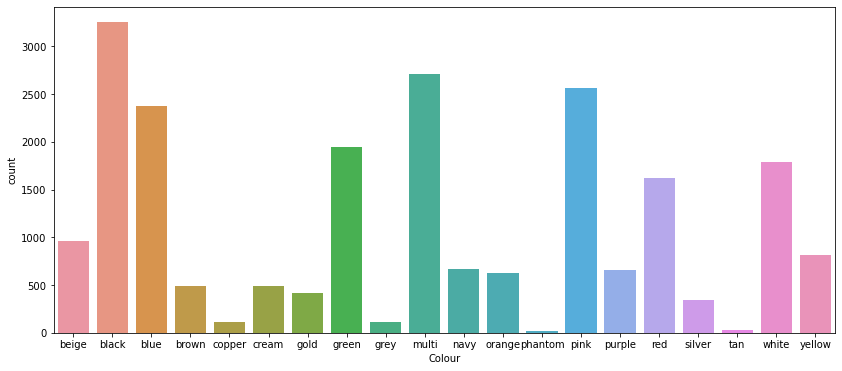

In [11]:
plt.figure(figsize=(14, 6))
sns.countplot(df.Colour)
# black is maximum followed by multi and pink color

In [12]:
# Cleaning Catagories column 
df['tokens'] = df['Catagories'].str.split(', ')
df['tokens']
 
all_tokens = [token for sublist in df['tokens'].tolist() for token in sublist]
unique_tokens = list(set(all_tokens))
len(unique_tokens)

296

In [13]:
nltk.download('punkt')
nltk.download('stopwords')
 
stop_words = set(stopwords.words('english'))
p = inflect.engine() # inflect is used to see plural of words
 
def clean_text(text):
    text = re.sub(r'[-/]', ' ', text)     # Remove hyphens and slashes
    text = re.sub(r'[^\w\s]', '', text.lower())     # Remove punctuation and lowercase the text
    tokens = word_tokenize(text)     # Tokenize and remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Convert plural words to singular
    tokens = [p.singular_noun(word) if p.singular_noun(word) else word for word in tokens]
    return ''.join(tokens)
 
def clean_dataframe_column(df, column):
    df[column] = df[column].apply(lambda x: ', '.join([clean_text(token) for token in x.split(', ')]))
    return df
 
df = clean_dataframe_column(df, 'Catagories')
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kids\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kids\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Brand,Colour,Catagories,Price,tokens
0,Stella McCartney,beige,dress,111,[dresses]
1,Reformation,beige,dress,50,[dresses]
2,Ghost,beige,dress,75,[dresses]
3,Coucoo,beige,dress,37,[dresses]
4,RIXO,beige,dress,47,[dresses]


In [14]:
df.Catagories.unique()

array(['dress', 'dress, midi', 'bottom', ...,
       'dress, vinylpvcsynthetic, smart, formal, winter, seasonal, mini, vneck',
       'dress, cottonjersey, tiefront, skinnyfit, smart, formal, summer, midi, pencil, monochrome',
       'dress, woolcashmere, horizontalstripe, casual, winter, mini, shortsleeve'],
      dtype=object)

In [15]:
df.drop(['tokens'],axis=1,inplace=True)

In [16]:
ohe_data = df['Catagories'].str.get_dummies(sep=',') # encoding the data
 
df = pd.concat([df,ohe_data],axis=1)
print(df.columns.tolist())

['Brand', 'Colour', 'Catagories', 'Price', ' ', ' 34sleeve', ' abstract', ' animalprint', ' applique', ' apron', ' asymmetric', ' autumn', ' aztec', ' babyblue', ' back', ' balloonsleeve', ' bandage', ' baroque', ' beach', ' beaded', ' beige', ' bell', ' belle', ' bellsleeve', ' belt', ' black', ' blacktie', ' blue', ' bodice', ' bodycon', ' boho', ' bold', ' bow', ' boxy', ' bran', ' bright', ' broderieanglaise', ' burgundy', ' bustier', ' button', ' cami', ' camo', ' casual', ' chain', ' chainmail', ' chambray', ' check', ' checked', ' checkered', ' chic', ' chunky', ' collar', ' colour', ' colourful', ' coord', ' corset', ' cotton', ' cottonjersey', ' cowlneck', ' cream', ' crepe', ' crewneck', ' crochet', ' crop', ' cuff', ' cuffsleeve', ' cut', ' dark', ' delavali', ' delicate', ' denim', ' detail', ' diamonte', ' dianevonfurstenberg', ' distressed', ' drawstring', ' dres', ' dress', ' drillcuff', ' drillhem', ' dvf', ' elegant', ' embellished', ' embellishedformal', ' emerald', '

In [17]:
df_encoded = pd.get_dummies(df, columns=['Brand','Colour']) # encoding the data
df = pd.concat([df,df_encoded],axis=1)
df.head()

,Brand,Colour,Catagories,Price,,34sleeve,abstract,animalprint,applique,apron,...,Colour_navy,Colour_orange,Colour_phantom,Colour_pink,Colour_purple,Colour_red,Colour_silver,Colour_tan,Colour_white,Colour_yellow
0,Stella McCartney,beige,dress,111,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Reformation,beige,dress,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ghost,beige,dress,75,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Coucoo,beige,dress,37,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,RIXO,beige,dress,47,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df.drop(['Brand','Catagories','Colour'],axis=1,inplace=True) #dropping as these columns have been encoded

In [19]:
df

,Price,,34sleeve,abstract,animalprint,applique,apron,asymmetric,autumn,aztec,...,Colour_navy,Colour_orange,Colour_phantom,Colour_pink,Colour_purple,Colour_red,Colour_silver,Colour_tan,Colour_white,Colour_yellow
0,111,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,75,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,37,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29992,102,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
29993,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
29994,75,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
29995,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
x = df.drop('Price', axis=1)
y = df['Price']

In [21]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(1))

In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
550/550 [==============================] - 8s 9ms/step - loss: 5119.2676 - val_loss: 4408.9233
Epoch 2/50
550/550 [==============================] - 4s 7ms/step - loss: 4165.0273 - val_loss: 3595.0435
Epoch 3/50
550/550 [==============================] - 4s 7ms/step - loss: 3452.7244 - val_loss: 2971.5911
Epoch 4/50
550/550 [==============================] - 3s 6ms/step - loss: 2913.4456 - val_loss: 2505.2908
Epoch 5/50
550/550 [==============================] - 4s 7ms/step - loss: 2516.7939 - val_loss: 2168.3569
Epoch 6/50
550/550 [==============================] - 4s 7ms/step - loss: 2237.2175 - val_loss: 1937.8500
Epoch 7/50
550/550 [==============================] - 3s 6ms/step - loss: 2053.0596 - val_loss: 1792.0938
Epoch 8/50
550/550 [==============================] - 3s 6ms/step - loss: 1942.3364 - val_loss: 1708.7612
Epoch 9/50
550/550 [==============================] - 3s 6ms/step - loss: 1883.1199 - val_loss: 1667.3925
Epoch 10/50
550/550 [=========================

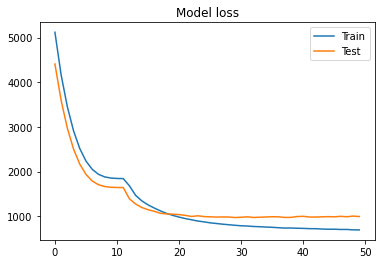

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.legend(['Train', 'Test'])
plt.show()

# Classification

In [25]:
df = pd.read_excel('Bike Sales Dashboard.xlsx')
df

,ID,Martial Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Age Brackets,Purchased Bike
0,12496,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,Middle Age,No
1,24107,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,Middle Age,No
2,14177,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,Old,No
3,24381,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41,Middle Age,Yes
4,25597,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36,Middle Age,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000,2,High School,Professional,Yes,2,2-5 Miles,North America,54,Middle Age,Yes
996,28672,Single,Male,70000,4,Graduate Degree,Professional,Yes,0,2-5 Miles,North America,35,Middle Age,Yes
997,11809,Married,Male,60000,2,Bachelors,Skilled Manual,Yes,0,0-1 Miles,North America,38,Middle Age,Yes
998,19664,Single,Male,100000,3,Bachelors,Management,No,3,1-2 Miles,North America,38,Middle Age,No


In [26]:
df.ID.nunique()

1000

In [27]:
df.drop(['ID'],axis=1,inplace = True)

In [28]:
df

,Martial Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Age Brackets,Purchased Bike
0,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,Middle Age,No
1,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,Middle Age,No
2,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,Old,No
3,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41,Middle Age,Yes
4,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36,Middle Age,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Married,Male,60000,2,High School,Professional,Yes,2,2-5 Miles,North America,54,Middle Age,Yes
996,Single,Male,70000,4,Graduate Degree,Professional,Yes,0,2-5 Miles,North America,35,Middle Age,Yes
997,Married,Male,60000,2,Bachelors,Skilled Manual,Yes,0,0-1 Miles,North America,38,Middle Age,Yes
998,Single,Male,100000,3,Bachelors,Management,No,3,1-2 Miles,North America,38,Middle Age,No


In [29]:
df.isna().sum()

Martial Status      0
Gender              0
Income              0
Children            0
Education           0
Occupation          0
Home Owner          0
Cars                0
Commute Distance    0
Region              0
Age                 0
Age Brackets        0
Purchased Bike      0
dtype: int64

In [30]:
df.duplicated().sum()

49

In [31]:
df.drop_duplicates(inplace=True)

In [32]:
for col in df.columns:
    unique_values = df[col].unique()
    print(f"{col}: {unique_values}")

Martial Status: ['Married' 'Single']
Gender: ['Female' 'Male']
Income: [ 40000  30000  80000  70000  10000 160000  20000 120000  90000 170000
  60000 100000 130000 150000  50000 110000]
Children: [1 3 5 0 2 4]
Education: ['Bachelors' 'Partial College' 'High School' 'Partial High School'
 'Graduate Degree']
Occupation: ['Skilled Manual' 'Clerical' 'Professional' 'Manual' 'Management']
Home Owner: ['Yes' 'No']
Cars: [0 1 2 4 3]
Commute Distance: ['0-1 Miles' '2-5 Miles' '5-10 Miles' '1-2 Miles' 'More than 10 Miles']
Region: ['Europe' 'Pacific' 'North America']
Age: [42 43 60 41 36 50 33 58 40 54 55 35 45 38 59 47 56 34 63 29 44 32 26 31
 62 30 28 65 48 66 46 52 39 61 37 68 51 25 49 53 27 67 57 70 78 69 64 89
 80 73 74 71 72]
Age Brackets: ['Middle Age' 'Old' 'Adolescent']
Purchased Bike: ['No' 'Yes']


In [33]:
le = LabelEncoder()
col = ['Martial Status', 'Gender','Home Owner', 'Region', 'Purchased Bike']
for i in col:
    df[i] = le.fit_transform(df[i])
    
# For the others, mapping where order matters to give importance
df['Education'] = df['Education'].map({'Partial High School': 0, 'High School': 1, 'Partial College': 2, 'Bachelors': 3, 'Graduate Degree': 4})
df['Occupation'] = df['Occupation'].map({'Clerical': 0, 'Manual': 1,'Skilled Manual': 2,'Management': 3,'Professional': 4})
df['Commute Distance'] = df['Commute Distance'].map({'0-1 Miles': 0, '1-2 Miles': 1, '2-5 Miles': 2, '5-10 Miles': 3, 'More than 10 Miles': 4})
df['Age Brackets'] = df['Age Brackets'].map({'Adolescent': 0,'Middle Age':1 , 'Old': 2 })

<AxesSubplot:>

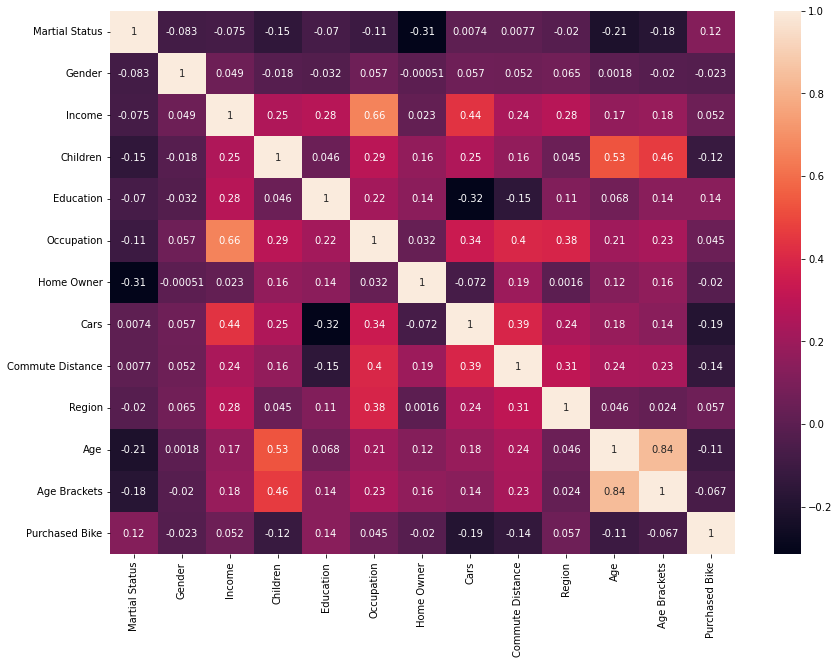

In [34]:
corr = df.corr()
plt.figure(figsize=(14, 10))

sns.heatmap(corr,annot=True)

In [35]:
# High correlation seen between age and age brackets, dropping age brackets
df.drop(['Age Brackets'],axis=1,inplace=True)

In [36]:
# Splitting data
x = df.drop('Purchased Bike', axis=1)
y = df['Purchased Bike']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [37]:
x_train.shape

(760, 11)

In [38]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [39]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [40]:
optimizer = Adam(learning_rate=0.0001) # lr decreased as loss was fluctuating in a zig-zag fashion, default is 0.01
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                192       
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 337 (1.32 KB)
Trainable params: 337 (1.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
history = model.fit(x_train, y_train, epochs=50, batch_size=12,validation_data=(x_test, y_test))

Epoch 1/50
64/64 [==============================] - 2s 8ms/step - loss: 0.7131 - accuracy: 0.5408 - val_loss: 0.7089 - val_accuracy: 0.5236
Epoch 2/50
64/64 [==============================] - 0s 4ms/step - loss: 0.7080 - accuracy: 0.5447 - val_loss: 0.7043 - val_accuracy: 0.5393
Epoch 3/50
64/64 [==============================] - 0s 4ms/step - loss: 0.7034 - accuracy: 0.5566 - val_loss: 0.6998 - val_accuracy: 0.5497
Epoch 4/50
64/64 [==============================] - 0s 4ms/step - loss: 0.6991 - accuracy: 0.5684 - val_loss: 0.6959 - val_accuracy: 0.5602
Epoch 5/50
64/64 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5737 - val_loss: 0.6920 - val_accuracy: 0.5707
Epoch 6/50
64/64 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5763 - val_loss: 0.6884 - val_accuracy: 0.5707
Epoch 7/50
64/64 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5855 - val_loss: 0.6849 - val_accuracy: 0.5812
Epoch 8/50
64/64 [==

In [42]:
loss, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %f' % (accuracy*100))

6/6 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6754
Accuracy: 67.539269


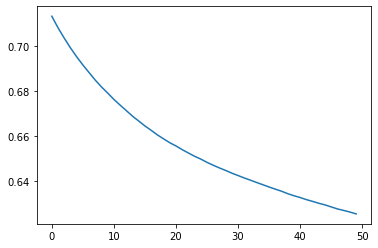

In [43]:
plt.plot(history.history['loss']) # gradually decreasing loss, hence acceptable

# Manual Neural Network Dummy

In [44]:
# activation functions
def sigmoid(z):
    a = 1/(1+np.exp(-z))
    return a

def tanh(z):
    a = (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
    return a

def relu(z):
    a = np.maximum(0,z)
    return a

def leaky(z):
    a = np.maximum(0.01*z,z) #doing (0.01,z) is okay too
    return a

def softmax(z):
    e = np.exp(z)
    a = e/e.sum()
    return a

In [45]:
#derivatives
def dsigmoid(a):
    d = a*(1-a)
    return d

def dtanh(a):
    d = (1-a**2)
    return d

def drelu(a):
    d = (np.int64(s>0)) #s>0 creates boolean array, +ve = T, -ve = f. np.int4 converts T to 1 and F to 0
    return d

def dleaky(a,alpha = 0.01):
    d = np.where(s>0.01,1,alpha)
    return d

In [46]:
nx = 2
m=3
x = np.random.randn(2,3)
y = (np.random.randn(1,3)>0)

# forward propagation
def layers_size(x,y,node):
    nx = x.shape[0]
    nh = node
    ny = y.shape[0]
    return nx,nh,ny

def intz(nx,nh,ny):
    np.random.seed(2)
    w1 = np.random.rand(nh,nx)*0.01
    b1 = np.zeros((nh,1))
    w2 = np.random.rand(ny,nh)*0.01
    b2 = np.zeros((ny,1))
    parameters={'w1':w1,'b1':b1,'w2':w2,'b2':b2}
    return parameters

def fwd(x,parameters):
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    z1 = np.dot(w1,x) + b1
    a1 = tanh(z1)
    z2 = np.dot(w2,a1) + b2
    a2 = sigmoid(z2)
    cache={'z1':z1,'z2':z2,'a1':a1,'a2':a2}
    return a2,cache

def compute_cost(a2,y):
    m = y.shape[1]
    logp = np.multiply(np.log(a2),y) + np.multiply(np.log(1-a2),(1-y)) #logistic loss function
    cost = -np.sum(logp)/m
    cost = float(np.squeeze(cost))
    return cost
    
nx,nh,ny = layers_size(x,y,4)
parameters = intz(nx,nh,ny)
a2,cache = fwd(x,parameters)
print(parameters)
print('cost is:',compute_cost(a2,y))

{'w1': array([[0.00435995, 0.00025926],
       [0.00549662, 0.00435322],
       [0.00420368, 0.00330335],
       [0.00204649, 0.00619271]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.]]), 'w2': array([[0.00299655, 0.00266827, 0.00621134, 0.00529142]]), 'b2': array([[0.]])}
cost is: 0.6931324529800568


iteration: 0 cost is: 0.693132
iteration: 100 cost is: 0.671236
iteration: 200 cost is: 0.657917
iteration: 300 cost is: 0.649762
iteration: 400 cost is: 0.644723
iteration: 500 cost is: 0.641570
iteration: 600 cost is: 0.639556
iteration: 700 cost is: 0.638221
iteration: 800 cost is: 0.637269
iteration: 900 cost is: 0.636498


{'w1': array([[0.00399715, 0.01483105],
        [0.00484874, 0.03198794],
        [0.00322104, 0.04417298],
        [0.00094854, 0.05341823]]),
 'w2': array([[0.01532427, 0.03210591, 0.04511933, 0.05403049]]),
 'b1': array([[0.00300556],
        [0.00509144],
        [0.00798627],
        [0.00884406]]),
 'b2': array([[0.6234906]])}

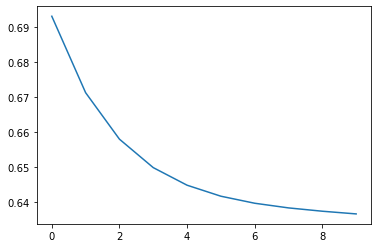

In [47]:
# Backward Propagation
def bwp(parameters,x,y,cache):
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    a1 = cache['a1']
    a2 = cache['a2']
    m = y.shape[1]
    dz2 = a2-y
    dw2 = np.dot(dz2,a1.T)/m
    db2 = np.sum(dz2,axis=1,keepdims=True)/m #axis = 1 does sum horizontally
    da1 = np.dot(w2.T,dz2)
    
    dz1 = da1*dtanh(a1) #instead of dtanh u can write (1-np.power(a1,2)) or (1-a)**2
    dw1 = np.dot(dz1,x.T)/m
    db1 = np.sum(dz1,axis=1,keepdims=True)/m
    grads = {'dw1':dw1,'dw2':dw2,'db1':db1,'db2':db2}
    return grads    

def update(parameters,grads,lr):
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    dw1 = grads['dw1']
    db1 = grads['db1']
    dw2 = grads['dw2']
    db2 = grads['db2']
    
    w1 = w1 - lr * dw1
    w2 = w2 - lr * dw2
    b1 = b1 - lr * db1
    b2 = b2 - lr * db2
    
    parameters = {'w1':w1,'w2':w2,'b1':b1,'b2':b2}
    return parameters 

def nn(x,y,epoch=1000,print_cost = True, lr = 0.01):
    np.random.seed(1)
    nx,nh,ny =layers_size(x,y,4)
    parameters = intz(nx,nh,ny)
    costs = []
    for i in range(epoch):
        a2,cache = fwd(x,parameters)
        cost = compute_cost(a2,y)
        grads = bwp(parameters,x,y,cache)
        parameters = update(parameters,grads,lr)
        if print_cost and i%100 == 0:
            print("iteration: %i cost is: %f"%(i,cost))
            costs.append(cost)
    plt.plot(costs)
    return parameters
nn(x,y)